# [Exploration 10] Shallow Focus Project 📷️

이번 프로젝트는 딥러닝을 이용한 프로젝트는 아니고, 사진에 아웃포커싱(아이폰의 인물사진모드)기능을 입혀보도록 하는 프로젝트이다.   
실제도 상당히 간단하게 작동하는데도 사소한 문제점이 있다. 이 프로젝트에서 2가지 루브릭은 이 문제점을 해결하는 방법에 초점이 맞춰져 있다.   
한번 진행해보도록 하겠다.

In [1]:
print('git test')

git test


# Step 1. 인물모드 직접 해 보기

# 1. 필요한 라이브러리 import

In [10]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

디렉토리는 다음과 같이 설정하였다.   
`$ mkdir -p ~/aiffel/human_segmentation/models`   
`$ mkdir -p ~/aiffel/human_segmentation/images`


# 2. 셸로우 포커스 사진 불러오기

In [11]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/person_riding_byc.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(667, 1000, 3)


인터넷에서 저작권에 상관없이 사용해도 상관없는 자전거타는 사람의 사진을 가져왔다.   
후에 나오겠지만 모델은 구글의 학습된 모델을 가져와서 사용하는데, lable에 자전거가 있어서 자전거로 테스트하기 위해서 일부러 자전거가 포함된 사진을  골라봤다.

# 3. DeepLab 모델 준비하기   
모델은 구글에서 제공하는 모델 구조를 그대로 가져다가 사용한다.   
DeepLab Demo : https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

In [12]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

이제는 학습된 모델과 가중치를 다운로드하여 model 디렉토리에 저장한다.

In [13]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj58/aiffel/human_segmentation/models
model loaded successfully!


준비된 이미지를 DeepLabModel 클래스를 사용하여 불러온다.

# 4. Image resize 및 mask 추출하기

In [14]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(667, 1000, 3) (342, 513, 3) 15


원본이미지의 shape은 (667, 1000)이었는데 resize하여 (342, 513)으로 줄어들었다.   
그리고 seg_map.max는 lable값중 가장 큰 비중을 차지하는 lable을 나타내는데, 15번째 lable인 사람이 가장 크게 나타나는 것 같다.   
레이블은 아래와 같다.

In [15]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

총 21개의 레이블이 있다.

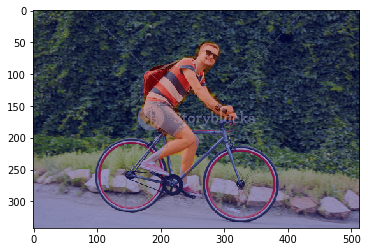

In [16]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

두번째 줄 코드를 보면 seg_map값을 15, 15, 0으로 줬다 즉, 사람값만 추출한 것이다. 사진에는 bicycle도 포함되어 있으므로 2번째 레이블은 자전거를 뽑아보겠다.

자전거만 잘 추출된것 같지는 않다..? 후에 다시 확인해보겠다.

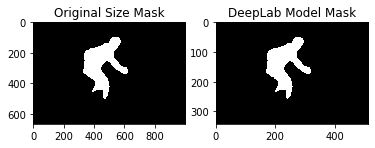

In [18]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

resize하여 mask를 추출한 사진을 다시 original shape크기로 바꿔준다.   
왼쪽사진이 다시 사이즈를 재조정한 사진이다.

# 5. Image 원본사이즈로 되돌리기 & blur 처리!

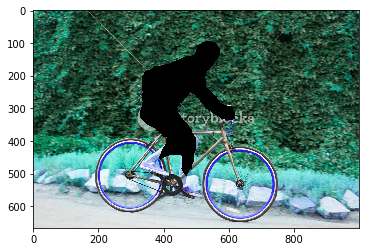

In [21]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

다음 스텝으로는 `bitwise_not`함수를 사용하여 이미지를 반전시켜준다. 255값은 0이 되고 0값은 255가 된다. 이는 `img_bg_mask`에 담겨있다.   
다음은 `bitwise_and`를 사용하여 배경만 담아준다.

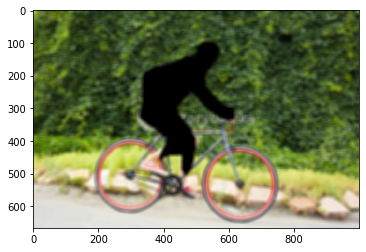

In [22]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

`bitwise_and`를 통해 `img_bg`에 배경사진만 담아뒀었는데, `cv2.blur`를 사용하여 blur처리를 해준다.   
13, 13보다 더 높은 값을 주면 더 많이 블러처리가 된다.

# 6. Image 합치기!

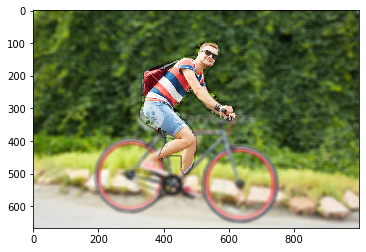

In [23]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

마지막 스텝으로 blur처리된 배경과 img_bg_mask를 합쳐주면 끝!   

### 문제점:
1. 발목부터 다리 부분이 짤렸다.   
2. 엉덩이부분의 워터마크가 같이 들어왔다.   
3. 부자연스러운 경계부분의 블러처리

# Step1. (2) 크로마키 배경전환

사진에서 위와같은 문제점이 발생하여서 자연스럽게는 안되겠지만, 바다에 서 있는 사진으로 합성을 한번 해보겠다.

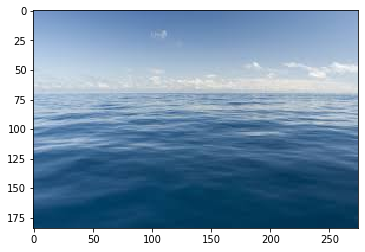

In [30]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pic_of_ocean.jpeg'
bg = cv2.imread(bg_path) 
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
plt.show()

배경이 될 바다 사진을 준비했다.   
이제 발목이 짤린 자전거타는 사람과 합성해보겠다.

## Size 맞추기

먼저, 대상이 될 사진의 size를 확인한 후 background사진의 크기를 맞춰준다.

In [44]:
img_orig.shape

(667, 1000, 3)

아마 세로가 667, 가로가 1000인것 같다.   
배경이될 사진의 크기도 resize해준다.

In [45]:
bg_resize = cv2.resize(bg, dsize=(1000, 667), interpolation=cv2.INTER_AREA)

동일하게 사이즈를 맞춰준 후, 합성시켜본다.

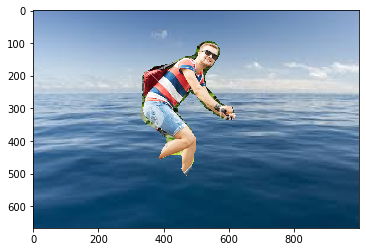

In [46]:
img_concat = np.where(img_mask_color==255, img_orig, bg_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

생각보다 꽤 그럴싸하다.

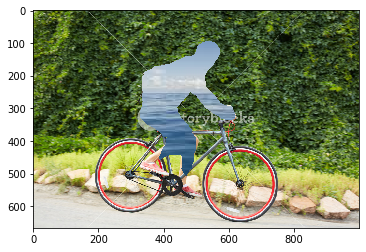

In [49]:
img_concat = np.where(img_mask_color==0, img_orig, bg_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#이것되 되네

# Step1. (3) 고양이 셸로우 포커스!

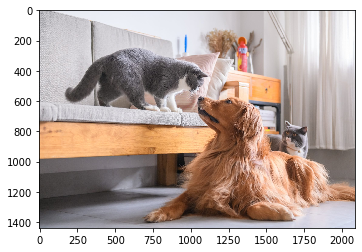

In [56]:
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
img_cat = cv2.imread(cat_path) 
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

고양이 사진을 불러온다.   
일부러 고양이 두마리와 강아지 사진이 들어있는 사진으로 골라봤다. 과연 강아지는 인식하지 않을까?

In [57]:
img_resized_cat, seg_map_cat = MODEL.run(img_cat)
print (img_cat.shape, img_resized_cat.shape, seg_map_cat.max())

(1438, 2086, 3) (353, 513, 3) 8


lable 8이 나왔다.   
**cat**의 레이블이 이 맞다.

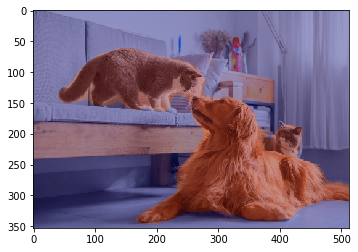

In [58]:
img_show_cat = img_resized_cat.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0) # 예측 중 고양이만 추출
cat_mask = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

왠지 강아지도 고양이로 인식한것 같다..

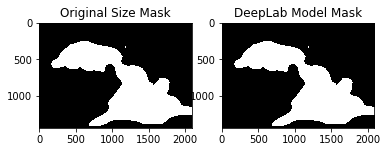

In [59]:
img_mask_up_cat = cv2.resize(cat_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

역시 강아지도 인식되어버렸다..

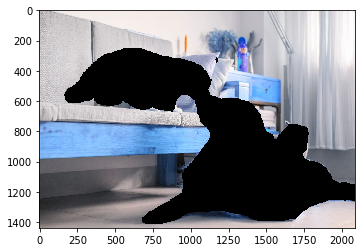

In [60]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_cat = cv2.bitwise_and(img_cat, img_bg_mask_cat)
plt.imshow(img_bg_cat)
plt.show()

고양이와 강아지는 마스크처리하고, 배경사진만 추출한다.

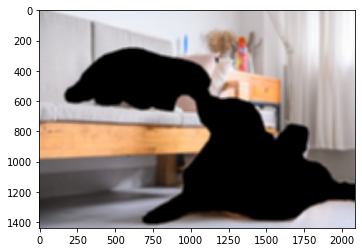

In [65]:
img_bg_blur_cat = cv2.blur(img_bg_cat, (25,25))
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

13,13의 블러처리가 조금 약한것 같아 25으로 처리하였다.

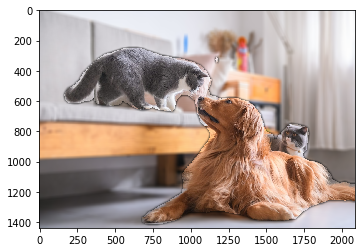

In [66]:
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

블러처리는 나름 잘 되었지만 고양이들과 강아지의 경계가 너무 어색하다. 알수없는 검은색 줄이 생겼다.